In [2]:
# Import all libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.cluster import KMeans
import collections

# Other Libraries
from imblearn.datasets import fetch_datasets
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import average_precision_score, precision_recall_curve, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, StratifiedShuffleSplit
import warnings
warnings.filterwarnings("ignore")

# Read data into a dataframe
df = pd.read_csv('../data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
random_seed = 42

## 1. First  have a look at the 'amount' attribute

In [4]:
print(np.mean(df[df["Class"]== 0]["Amount"].values), np.mean(df[df["Class"]== 1]["Amount"].values))

88.29102242231328 122.21132113821139


In [5]:
# Data standardization
df_copy = df.copy()

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df_copy['scaled_amount'] = rob_scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
df_copy.drop(['Time','Amount'], axis=1, inplace=True)
scaled_amount = df_copy['scaled_amount']
df_copy.drop(['scaled_amount'], axis=1, inplace=True)
df_copy.insert(0, 'scaled_amount', scaled_amount)

X_df = df_copy.drop('Class', axis=1)
y_df = df_copy['Class']

df_copy.head()

,scaled_amount,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## 2. Binary classification (benign or malicious)

In [6]:
# Split the dataset 
from sklearn.model_selection import train_test_split

X = X_df.values
y = y_df.values

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0, stratify=y)

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.5, random_state=random_seed)
for train_index, test_index in sss.split(X, y):
    #X_train, X_test = X[train_index], X[test_index]
    #y_train, y_test = y[train_index], y[test_index]
    X_train_df, X_test_df = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train_df, y_test_df = y_df.iloc[train_index], y_df.iloc[test_index]
X_train, X_test = X_train_df.values, X_test_df.values
y_train, y_test = y_train_df.values, y_test_df.values

X_test_df_original = df.iloc[test_index]    
    
# Use SMOTE for oversampling and then build the classifier
classifier = linear_model.SGDClassifier(loss = 'hinge',random_state=random_seed)
sm = SMOTE(ratio='minority', random_state=random_seed)
X_sm, y_sm = sm.fit_sample(X_train, y_train)
classifier.fit(X_sm, y_sm)
y_pred = classifier.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[138768   3390]
 [    26    220]]


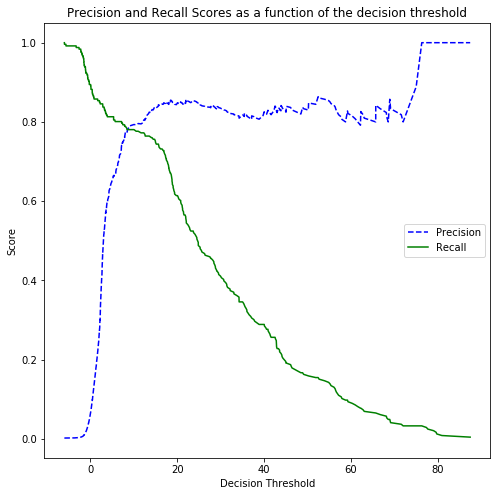

In [7]:
# The precision-recall by threshold
y_score = classifier.decision_function(X_test)
p, r, thresholds = precision_recall_curve(y_test, y_score)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    
# use the same p, r, thresholds that were previously calculated
plot_precision_recall_vs_threshold(p, r, thresholds)

In [8]:
# Confusion matrix by thresholds
def predict_thresold(model, X_test, threshold):
    y_score = model.decision_function(X_test)
    y_pred = np.zeros(y_score.shape[0])
    n_pos = 0
    for i in range(y_score.shape[0]):
        if y_score[i] > threshold:
            y_pred[i] = 1
            n_pos += 1
        else:
            y_pred[i] = 0
    return y_pred

def evaluate_threshold():
    thresholds = [-0.1*k for k in range(20)]
    for threshold in thresholds:
        y_pred = predict_thresold(classifier, X_test, threshold)
        print("###############################")
        print("Threshold: {}".format(threshold))
        print(confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))

#evaluate_threshold()

## 3. Use Clustering to get alert types then use OVA multi-class classification

In [14]:
# Clustering on the whole positive data
from sklearn.mixture import GaussianMixture
import copy

cluster_seed = 42
n_alert = 6
n_timestamp = 48
y_pred = predict_thresold(classifier, X_test, 0)

X_pos = X[np.where(y==1)[0]]
alert_cluster = GaussianMixture(n_components=n_alert, random_state=cluster_seed).fit(X_pos)
y_pos = alert_cluster.predict(X_pos)
y_pos += 1
print("Alert lables of X_pos: {}".format(collections.Counter(y_pos)))

X_train_pos = X_train[np.where(y_train==1)[0]]
y_train_pos = alert_cluster.predict(X_train_pos)
y_train_pos += 1
print("Alert lables of X_train_pos: {}".format(collections.Counter(y_train_pos)))

X_test_pos = X_test[np.where(y_test==1)[0]]
y_test_pos = alert_cluster.predict(X_test_pos)
y_test_pos += 1
print("Alert lables of X_test_pos: {}".format(collections.Counter(y_test_pos)))

# Multiclass classification with OVA
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC

clfs = []
alerts = [k+1 for k in range(n_alert)]

print()
print("Now train a binary classifier for each alert:")

# Get the true positive data in the test set
X_tp_alert = X_test[np.where(np.logical_and(y_test==1, y_pred==1))[0]]
y_tp_alert = alert_cluster.predict(X_tp_alert)
y_tp_alert += 1

for alert in alerts:    
    print("#################################")
    print("Alert type {}".format(alert))
    
    # Decompose the multiclass classification to binary classifications
    # Test on the true positive data!
    X_tr = copy.deepcopy(X_train_pos)
    y_tr = np.where(y_train_pos==alert, 1, 0)
    X_te = copy.deepcopy(X_tp_alert)
    y_te = np.where(y_tp_alert==alert, 1, 0)
    
    # Use SMOTE to oversampling on the data
    smote = SMOTE(ratio='minority', random_state=42)
    X_tr_sm, y_tr_sm = smote.fit_sample(X_tr, y_tr)
    
    # Train a classifier
    loss_alert = 'hinge'
    if alert != 6:
        clf_alert = linear_model.SGDClassifier(loss=loss_alert, random_state=random_seed)
        #clf_alert = SVC(kernel='linear', random_state=random_seed)
    else:
        #clf_alert = linear_model.SGDClassifier(loss=loss_alert, random_state=random_seed)
        clf_alert = RandomForestClassifier(n_estimators = 5, random_state = random_seed)
        #clf_alert = SVC(kernel='linear', random_state=random_seed)
    clf_alert.fit(X_tr_sm, y_tr_sm)
    
    # Test the classifier
    y_te_pred = clf_alert.predict(X_te)
    print(confusion_matrix(y_te, y_te_pred))
    print(classification_report(y_te, y_te_pred))
    
    clfs.append(clf_alert)

# Now test with the flase positive data
print()
print("Let's see the false positive data:")
X_fp_alert = X_test[np.where(np.logical_and(y_test==0, y_pred==1))[0]]

FP_pred_alert = []
FP_counts = []
for alert in alerts:    
    y_fp_pred = clfs[alert-1].predict(X_fp_alert)
    FP_counts.append(int(np.count_nonzero(y_fp_pred)/n_timestamp))
    print("Alert type: {}, Number of FP: {}".format(alert, np.count_nonzero(y_fp_pred)))
print("Average alert counts in each timestamp: {}".format(FP_counts))

# Now test with positive data
print()
print("Let's test with true positive data:")
for alert in alerts:    
    alert_triggered = []
    X_alert = X_tp_alert[np.where(y_tp_alert==alert)[0]]
    for clf_alert in clfs:
        y_alert = clf_alert.predict(X_alert)
        alert_triggered.append(round(np.count_nonzero(y_alert)/y_alert.shape[0], 2))
    print("Alert type: {}, detecttion: {}".format(alert, alert_triggered))            

Alert lables of X_pos: Counter({4: 250, 6: 124, 3: 72, 2: 21, 5: 14, 1: 11})
Alert lables of X_train_pos: Counter({4: 117, 6: 64, 3: 39, 2: 12, 1: 7, 5: 7})
Alert lables of X_test_pos: Counter({4: 133, 6: 60, 3: 33, 2: 9, 5: 7, 1: 4})

Now train a binary classifier for each alert:
#################################
Alert type 1
[[216   1]
 [  0   3]]
             precision    recall  f1-score   support

          0       1.00      1.00      1.00       217
          1       0.75      1.00      0.86         3

avg / total       1.00      1.00      1.00       220

#################################
Alert type 2
[[207   4]
 [  0   9]]
             precision    recall  f1-score   support

          0       1.00      0.98      0.99       211
          1       0.69      1.00      0.82         9

avg / total       0.99      0.98      0.98       220

#################################
Alert type 3
[[117  70]
 [  0  33]]
             precision    recall  f1-score   support

          0       1.00  

## 3. Get the mean amount of each attack types 

In [15]:
X_pos_df = df.loc[y==1]
attack_utility = []
attack_number = []
for alert in alerts:
    X_alert_df = X_pos_df.loc[y_pos==alert]
    attack_utility.append(round(X_alert_df['Amount'].mean(), 2))
    attack_number.append(X_alert_df.shape[0])
print("Utility of each type of attack: {}".format(attack_utility))
print("Number of each type of attack: {}".format(attack_number))

Utility of each type of attack: [93.74, 99.99, 93.55, 121.42, 2.31, 160.27]
Number of each type of attack: [11, 21, 72, 250, 14, 124]
